In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import os
import glob
from re import I
import pandas as pd
import numpy as np
import natsort
import datetime
import json
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "IPAexGothic"
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.cluster import KMeans
from collections import Counter
import load_data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns

In [6]:
# PATH
fitbit_path = '/Users/tomoki/projects/livnsU/lvnsU-2022/analysis_data/activities'
analysis_res = '/Users/tomoki/projects/livnsU/lvnsU-2022/analysis_results'
hr_path = "{}/hr".format(fitbit_path)
sleep_path = "{}/sleep".format(fitbit_path)
json_path = '/Users/tomoki/projects/livnsU/lvnsU-2022/analysis_data/data_collection_hr_sleep.json'
fig_res = "{}/figures".format(analysis_res)

# Make Folders
if not os.path.exists(analysis_res):
    os.mkdir(analysis_res)
if not os.path.exists(fig_res):
    os.mkdir(fig_res)

In [8]:
# Summarize info in JSON
if not os.path.exists(json_path):
    hr_data_paths = natsort.natsorted(glob.glob(os.path.join(hr_path, '*.txt')))
    sleep_data_paths = natsort.natsorted(glob.glob(os.path.join(sleep_path, '*.txt')))

    data_collection = {}
    for hr_data_path in hr_data_paths:
        date = os.path.basename(hr_data_path).split('.txt')[0]
        data_collection = load_data.get_Data_activity(hr_data_path, date, data_collection)

    value_list = [0] * data_collection['value'].shape[0]
    if 'sleep' not in data_collection:
        data_collection['sleep'] = np.array([])
    data_collection['sleep'] = np.append(data_collection['sleep'], np.array(value_list))

    for sleep_data_path in sleep_data_paths:
        data_collection = load_data.get_Data_sleep(sleep_data_path, data_collection)

    tmp_df = pd.DataFrame()
    tmp_df['time'] = data_collection['time'].tolist()
    tmp_df['time'] = tmp_df['time'].dt.strftime('%Y-%m-%d %H:%M:%S')

    data_collection['value'] = data_collection['value'].tolist()
    data_collection['time'] = tmp_df['time'].tolist()
    data_collection['sleep'] = data_collection['sleep'].tolist()

    with open(json_path, 'w') as f:
        json.dump(data_collection, f, indent=4)

# Read JSON as DataFrame
data_collection = pd.read_json(json_path)
data_collection.head()

,time,value,sleep
0,2022-06-03 00:00:00,0,0
1,2022-06-03 00:01:00,0,0
2,2022-06-03 00:02:00,0,0
3,2022-06-03 00:03:00,0,0
4,2022-06-03 00:04:00,0,0


In [11]:
# Merge Fitbit and Halshare data
file_halshare = '/Users/tomoki/projects/livnsU/lvnsU-2022/analysis_data/20220617_lvnsu003.csv'
halshare = pd.read_csv(file_halshare)
tmp_datetime = [tmp.split('+09')[0] for tmp in halshare['date_measured'].tolist()]
halshare['date_measured'] = tmp_datetime
halshare['date_measured'] = pd.to_datetime(halshare['date_measured'])
halshare = halshare.sort_values(by=['date_measured']) # ハルシェのデータは、時間でソートされていないのでソートを実行する
for i, tmp_datetime in enumerate(halshare['date_measured'].tolist()):
    str_datetime = datetime.datetime.strftime(tmp_datetime, '%Y-%m-%d %H:%M:%S')[:-2] + '00'
    if str_datetime in data_collection['time'].values:
        data_collection.loc[data_collection['time']==str_datetime, 'temperature'] = halshare['temperature'][i]

data_collection = data_collection[(data_collection['value'] != 0) & (data_collection['temperature'] != 0) ].dropna(how='any').reset_index(drop=True)
data_collection.head()

,time,value,sleep,temperature
0,2022-06-03 21:43:00,64,0,31.1875
1,2022-06-03 21:48:00,71,0,31.5000
2,2022-06-03 21:53:00,61,0,31.6875
3,2022-06-03 21:58:00,74,0,31.8750
4,2022-06-03 22:03:00,74,0,32.1875


In [13]:
def stats_daily_data(daily_data, save_path):
    df_average = {
                'date':[], 'whole_hb_average':[], 
                'wake_hb_min':[], 'wake_hb_max':[], 'wake_hb_mean':[], 'wake_hb_median':[], 'wake_hb_std':[],
                'sleep_hb_min':[], 'sleep_hb_max':[], 'sleep_hb_mean':[], 'sleep_hb_median':[], 'sleep_hb_std':[],
                'wake_temp_min':[], 'wake_temp_max':[], 'wake_temp_mean':[], 'wake_temp_median':[], 'wake_temp_std':[],
                'sleep_temp_min':[], 'sleep_temp_max':[], 'sleep_temp_mean':[], 'sleep_temp_median':[], 'sleep_temp_std':[]
                }
    daily_data['time'] = pd.to_datetime(daily_data['time'])
    time = daily_data['time'].tolist()
    datetime_start = time[0]
    datetime_end = time[-1]
    f_date = datetime_start
    for _ in range((datetime_end - datetime_start).days):
        date = datetime.datetime(f_date.year, f_date.month, f_date.day)
        df_average['date'].append(date)
        st = f_date
        en = f_date + datetime.timedelta(days=1) - datetime.timedelta(minutes=1)
        tmp_df = daily_data[(daily_data['time'] > st) & (daily_data['time'] < en)] # 1日のFitbitデータとハルシェの体温データが格納される
        tmp_df = tmp_df[tmp_df['value']!=0]
        #=======演習1=======
        df_average['whole_hb_average'].append(tmp_df['value'].mean())
        df_average['wake_hb_min'].append(tmp_df.loc[tmp_df['sleep']==0.0, 'value'].min())
        df_average['wake_hb_max'].append(tmp_df.loc[tmp_df['sleep']==0.0, 'value'].max())
        df_average['wake_hb_mean'].append(tmp_df.loc[tmp_df['sleep']==0.0, 'value'].mean())
        df_average['wake_hb_median'].append(tmp_df.loc[tmp_df['sleep']==0.0, 'value'].median())
        df_average['wake_hb_std'].append(tmp_df.loc[tmp_df['sleep']==0.0, 'value'].std())
        df_average['sleep_hb_min'].append(tmp_df.loc[tmp_df['sleep']==1.0, 'value'].min())
        df_average['sleep_hb_max'].append(tmp_df.loc[tmp_df['sleep']==1.0, 'value'].max())
        df_average['sleep_hb_mean'].append(tmp_df.loc[tmp_df['sleep']==1.0, 'value'].mean())
        df_average['sleep_hb_median'].append(tmp_df.loc[tmp_df['sleep']==1.0, 'value'].median())
        df_average['sleep_hb_std'].append(tmp_df.loc[tmp_df['sleep']==1.0, 'value'].std())
        df_average['wake_temp_min'].append(tmp_df.loc[tmp_df['sleep']==0.0, 'temperature'].min())
        df_average['wake_temp_max'].append(tmp_df.loc[tmp_df['sleep']==0.0, 'temperature'].max())
        df_average['wake_temp_mean'].append(tmp_df.loc[tmp_df['sleep']==0.0, 'temperature'].mean())
        df_average['wake_temp_median'].append(tmp_df.loc[tmp_df['sleep']==0.0, 'temperature'].median())
        df_average['wake_temp_std'].append(tmp_df.loc[tmp_df['sleep']==0.0, 'temperature'].std())
        df_average['sleep_temp_min'].append(tmp_df.loc[tmp_df['sleep']==1.0, 'temperature'].min())
        df_average['sleep_temp_max'].append(tmp_df.loc[tmp_df['sleep']==1.0, 'temperature'].max())
        df_average['sleep_temp_mean'].append(tmp_df.loc[tmp_df['sleep']==1.0, 'temperature'].mean())
        df_average['sleep_temp_median'].append(tmp_df.loc[tmp_df['sleep']==1.0, 'temperature'].median())
        df_average['sleep_temp_std'].append(tmp_df.loc[tmp_df['sleep']==1.0, 'temperature'].std())
        #===ここまでが演習1===
        f_date += datetime.timedelta(days=1)
    df_result = pd.DataFrame(df_average).dropna(how='any')
    return df_result

In [14]:
df_average = stats_daily_data(data_collection, fig_res)
df_average.head()

,date,whole_hb_average,wake_hb_min,wake_hb_max,wake_hb_mean,wake_hb_median,wake_hb_std,sleep_hb_min,sleep_hb_max,sleep_hb_mean,...,wake_temp_min,wake_temp_max,wake_temp_mean,wake_temp_median,wake_temp_std,sleep_temp_min,sleep_temp_max,sleep_temp_mean,sleep_temp_median,sleep_temp_std
0,2022-06-03,67.904762,52,112,74.750000,72.0,14.482041,47.0,70.0,53.752809,...,28.8125,35.7500,33.161345,33.06250,1.256870,31.8125,35.4375,33.797051,34.0625,1.035686
1,2022-06-04,77.923954,57,127,84.740000,84.0,14.603380,50.0,68.0,56.285714,...,28.3750,35.8750,32.734063,32.71875,1.271826,32.1250,35.8125,34.866071,35.0000,0.827243
2,2022-06-05,76.209790,59,122,90.461988,91.0,11.963302,48.0,94.0,55.017391,...,25.0000,35.7500,32.845395,33.56250,2.464018,31.2500,35.6875,34.030435,34.1250,0.918274
4,2022-06-07,76.716599,50,135,87.536585,87.0,13.552167,48.0,72.0,55.337349,...,32.3125,35.4375,34.029726,34.25000,0.794635,32.6875,35.6250,34.638554,34.8125,0.704140
5,2022-06-08,70.211679,63,117,79.099338,77.0,8.923194,51.0,85.0,59.300813,...,27.9375,35.3125,33.433775,33.62500,1.316922,31.6250,35.5000,34.116870,34.3750,0.973061


In [15]:
#=======演習2=======
# tsneやumapを用いて、data_matrixを2次元のデータに変換し、X_decompに結果を格納せよ。
# また、次元削減されたデータX_decompを可視化せよ
def try_create_2d_umap(df, save_path, n_neighbors_list= [2, 3, 4, 5, 6]):
    fig, axes = plt.subplots(nrows=1, ncols=len(n_neighbors_list),figsize=(5*len(n_neighbors_list), 4))
    for i, (ax, n_neighbors) in enumerate(zip(axes.flatten(), n_neighbors_list)):
        mapper = umap.UMAP(n_components=2, random_state=0, n_neighbors=n_neighbors)
        X_decomp = mapper.fit_transform(df.values)
        ax.scatter(X_decomp[:, 0], X_decomp[:, 1])
        ax.set_title("n_neighbors_list: {}".format(n_neighbors))
    plt.savefig("{}/umap_search_n_neighbors.png".format(save_path))
    plt.show()
    
def main_umap(df, save_path, n_neighbors= 2):
    fig = plt.figure(figsize=(10,10))
    mapper = umap.UMAP(n_components=2, random_state=0, n_neighbors=n_neighbors)
    X_decomp = mapper.fit_transform(df.values)
    plt.scatter(X_decomp[:, 0], X_decomp[:, 1])
    plt.title("n_neighbors_list: {}".format(n_neighbors))
    plt.savefig("{}/umap_n_neighbors{}.png".format(save_path, n_neighbors))
    fig.show()
    np.save(os.path.join(save_path, 'fitbitX'), X_decomp[:,0])
    np.save(os.path.join(save_path, 'fitbitY'), X_decomp[:,1])
    return X_decomp

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


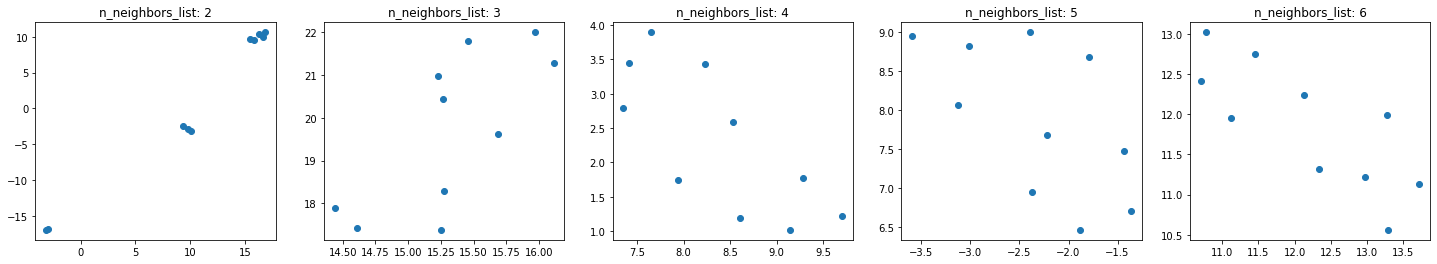

In [16]:
try_create_2d_umap(df_average.drop('date', axis=1), fig_res)

/var/folders/3b/g0w9k61n4hl5prpjmg3x93m80000gn/T/ipykernel_9787/3139773792.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


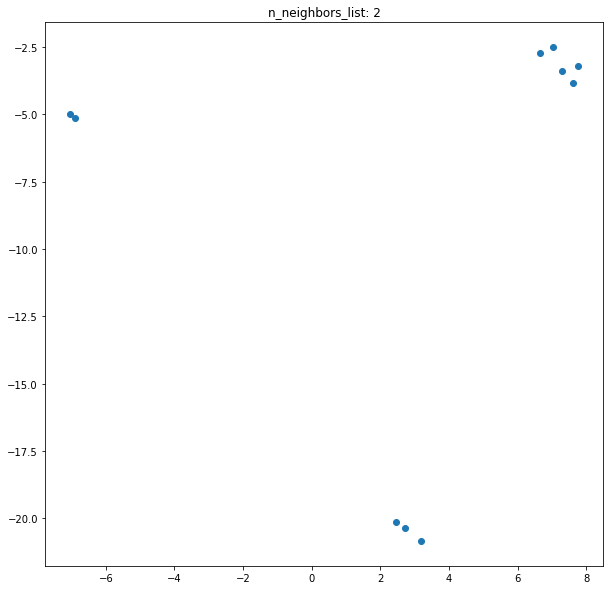

In [17]:
n_neighbors = 2
X_decomp = main_umap(df_average.drop('date', axis=1), fig_res, n_neighbors= n_neighbors)

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


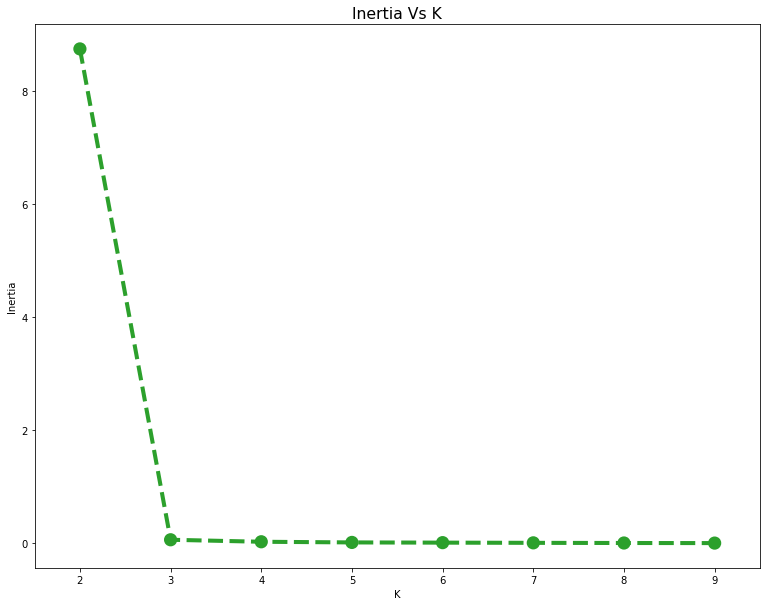

In [18]:
def scale_data(x):
    scaler = StandardScaler()
    scaler.fit(x)
    return scaler.transform(x)

def calculate_inertia(k, x) -> float:
    scaled_x = scale_data(x)
    model = KMeans(n_clusters=k)
    model.fit(scaled_x)
    return model.inertia_

inertias = [calculate_inertia(k, X_decomp) for k in range(2, 10)]
plt.figure(figsize = (13,10))
sns.pointplot(x=list(range(2, 10)) ,y=inertias , linestyles ='--',markers = 'o',scale=1.5, color='#2ca02c')
sns.set(font_scale=1.3)
plt.title('Inertia Vs K')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

In [19]:
def kmeans_daily_data(x, save_path, k):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)

#     tmp_X1 = np.load(os.path.join(save_path, 'fitbitX.npy'))
#     tmp_X2 = np.load(os.path.join(save_path, 'fitbitY.npy'))
#     X_decomp = np.zeros((tmp_X1.shape[0], 2))
#     X_decomp[:, 0] = tmp_X1
#     X_decomp[:, 1] = tmp_X2

    #=======演習3=======
    # 次元削減さらえたデータX_decompを用いて、クラスタリングせよ。
    # なお、クラスタリングにはscikit-learnのK-meansを用いること。
    # また、辞書型の変数label_values_indを以下のように定義せよ。
    # label_values_ind = {0:ラベル0のX_decompの値, 1:ラベル1のX_decompの値}
    scaled_x = scale_data(x)
    model = KMeans(n_clusters=k)
    model.fit(scaled_x)
    label_values_ind = model.labels_
    label_values_unique = np.unique(label_values_ind)
    #===ここまでが演習3===

    #=======演習4=======
    # ここで、matplotlibで散布図を作成し、クラスタごとに点の色を変更せよ。

    # クラスタの重心（クラスタ内の座標値の平均）を計算し、クラスタの重心を散布図上に示せ。
    # また、クラスタ内のデータの平均を求め、図内で可視化せよ。
    cluster_centers_ind = model.cluster_centers_
    colors = cm.rainbow(np.linspace(0, 1, len(label_values_unique)))
    sns.scatterplot(x=scaled_x[:,0], y=scaled_x[:,1], hue=label_values_ind, sizes=200)
    for i, color in zip(label_values_unique,colors):
        x_ind = cluster_centers_ind[i, 0]  # x座標の平均
        y_ind = cluster_centers_ind[i, 1]  # y座標の平均
        ax.scatter(x_ind, y_ind, s=200, label="Center:Label-{}".format(i),color=color,marker='*', linewidth=0.5)
        ax.text(x_ind*1.05, y_ind*1.1, "({:.2f}, {:.2f})".format(x_ind,y_ind), size=15 ,color='#555555') # クラスタの重心の点の近くにテキストを表示
    #===ここまでが演習4===
    plt.legend()
    fig.show()
    plt.savefig(os.path.join(save_path, 'kmeans_fig.png'))
    return label_values_ind

/var/folders/3b/g0w9k61n4hl5prpjmg3x93m80000gn/T/ipykernel_9787/2531573101.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,date,whole_hb_average,wake_hb_min,wake_hb_max,wake_hb_mean,wake_hb_median,wake_hb_std,sleep_hb_min,sleep_hb_max,sleep_hb_mean,...,wake_temp_max,wake_temp_mean,wake_temp_median,wake_temp_std,sleep_temp_min,sleep_temp_max,sleep_temp_mean,sleep_temp_median,sleep_temp_std,labels
0,2022-06-03,67.904762,52,112,74.750000,72.0,14.482041,47.0,70.0,53.752809,...,35.7500,33.161345,33.06250,1.256870,31.8125,35.4375,33.797051,34.0625,1.035686,0
1,2022-06-04,77.923954,57,127,84.740000,84.0,14.603380,50.0,68.0,56.285714,...,35.8750,32.734063,32.71875,1.271826,32.1250,35.8125,34.866071,35.0000,0.827243,2
2,2022-06-05,76.209790,59,122,90.461988,91.0,11.963302,48.0,94.0,55.017391,...,35.7500,32.845395,33.56250,2.464018,31.2500,35.6875,34.030435,34.1250,0.918274,2
4,2022-06-07,76.716599,50,135,87.536585,87.0,13.552167,48.0,72.0,55.337349,...,35.4375,34.029726,34.25000,0.794635,32.6875,35.6250,34.638554,34.8125,0.704140,2
5,2022-06-08,70.211679,63,117,79.099338,77.0,8.923194,51.0,85.0,59.300813,...,35.3125,33.433775,33.62500,1.316922,31.6250,35.5000,34.116870,34.3750,0.973061,0
6,2022-06-09,74.733096,60,114,79.907767,79.0,10.297347,53.0,73.0,60.520000,...,35.8750,33.743022,34.00000,0.988736,32.0625,35.8125,34.365000,34.8125,1.059019,1
7,2022-06-10,76.663934,59,119,86.160256,83.0,13.203859,51.0,77.0,59.829545,...,35.3750,33.608173,33.68750,0.775453,31.8750,35.2500,33.634233,33.4375,0.908855,1
8,2022-06-11,82.568702,53,131,90.447761,91.0,13.814431,48.0,80.0,56.606557,...,36.0625,32.567475,32.50000,1.209684,32.1875,35.6250,33.860656,33.9375,0.937180,2
11,2022-06-14,76.461207,57,145,86.816993,83.0,13.099537,50.0,67.0,56.405063,...,36.1875,34.035948,33.93750,0.880787,31.1875,35.2500,33.172468,33.0000,1.410321,2
12,2022-06-15,69.712727,60,115,75.291005,73.0,9.981631,51.0,78.0,57.453488,...,35.2500,33.718254,33.81250,0.908794,32.0625,35.7500,34.499273,34.6875,0.866264,0


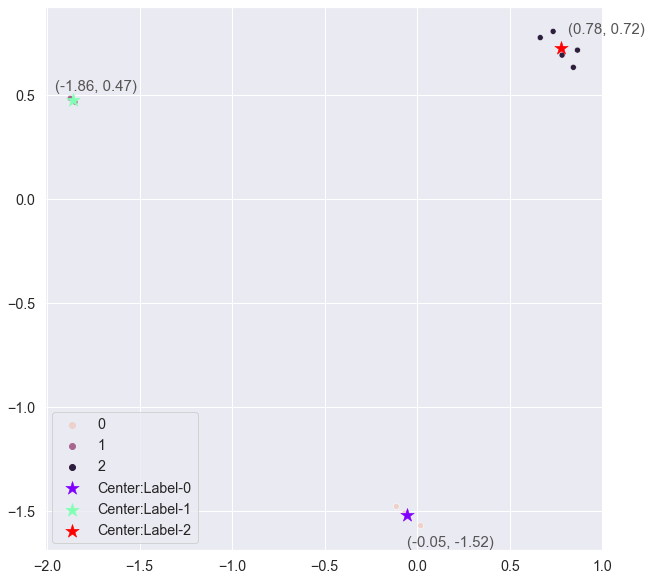

In [20]:
k=3  # The number of cluster
label_values_ind = kmeans_daily_data(X_decomp, fig_res, k=k)
df_average['labels'] = label_values_ind

#=======演習5=======
# ここで、df_averageの結果をcsvファイルに格納
df_average.to_csv("{}/result.csv".format(analysis_res), index=False)
df_average
#===ここまでが演習5===

In [21]:
def boxplot_cluster(df, save_path):
    col_list = df.columns.values[df.columns.str.contains('mean')]
    fig = plt.figure(figsize=(10,10))
    for i, col in enumerate(col_list):
        ax = fig.add_subplot(2, 2, i+1)
        sns.boxplot(x='labels', y=col, data=df, ax=ax)
        ax.set_ylabel(col)
    # show plots
    fig.tight_layout()
    fig.savefig("{}/boxplot_cluster.png".format(save_path))
    fig.show()

/var/folders/3b/g0w9k61n4hl5prpjmg3x93m80000gn/T/ipykernel_9787/2807057152.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


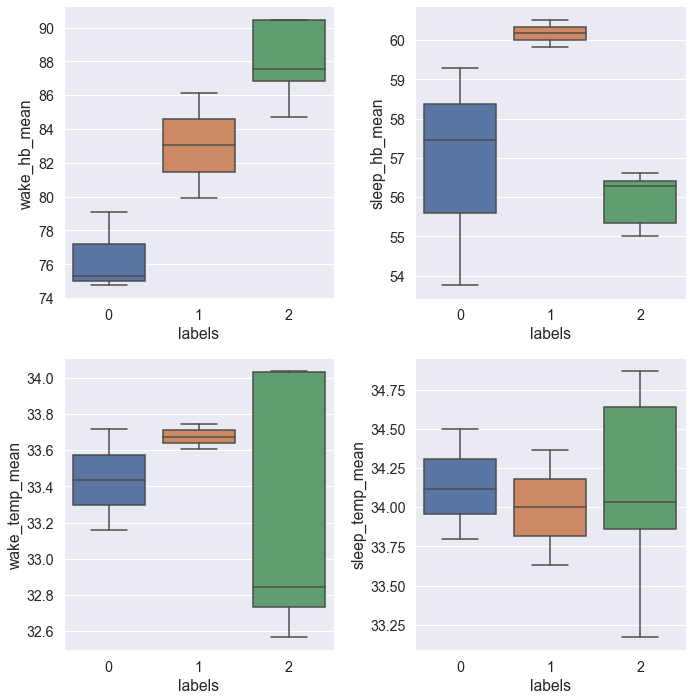

In [22]:
boxplot_cluster(df_average, fig_res)